## **Libraries**


In [0]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import pandas as pd
import numpy as np
import pandas_profiling
import re 
import time
import matplotlib.pyplot as plt  
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from collections import Counter
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold , train_test_split, cross_val_score, cross_validate , GridSearchCV, train_test_split, KFold
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score,confusion_matrix,plot_precision_recall_curve, recall_score, f1_score, log_loss , precision_recall_curve , roc_auc_score , make_scorer , average_precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler



In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Introduction**

We have data for a company (3D Technologies) which has a fleet of devices transmitting daily aggregated telemetry attributes. 
Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

### **Goal**
The goal of this work is to build a predictive model using machine learning to predict the probability of a device failure.


## **Definitions**

The following code will be the main core of the work. It will create a function that loads the data, cleans and transforms it. In addition, it will do the featuare engineering that it will be explained later on. Finally, some functions for scaling and spliting are made.



In [0]:
path = '/content/drive/My Drive/AWS/device_failure_utf.csv'

def load_df(path):
  '''Given a path, it loads a dataframe in pandas'''
  df = pd.read_csv(path)
  df.drop(['Unnamed: 0'], axis =1 , inplace= True)
  return df  

In [0]:
def add_datepart(df, fldname, drop=True):
    '''Adds features for a date type column to a dataframe in place.'''
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9

def feature_engineering(df):
  '''Performs feature engineering (FE) to the data. It does data FE, days FE, and device FE.'''
  df['date'] = df['date'].astype('datetime64[D]')

  add_datepart(df, 'date')

  failed = df[df['failure']==1]

  #Get the first and last day of reading 
  dates = df.groupby(['device']).agg({'date': [min, max]})
  dates.columns = dates.columns.droplevel(0)
  dates.reset_index()
  df = dates.merge(df, how = 'right', on = 'device')
  df['min'] = pd.to_datetime(df['min'])
  df['max'] = pd.to_datetime(df['max'])

  #Calculate the amount of days since the first and las reding.
  df['active_days'] = df['min'].sub(df['max'], axis=0)
  df['active_days'] = df['active_days'] / np.timedelta64(1, 'D') * (-1)

  #Add a day row representing age (in days) from inital date of installation 
  df.sort_values(['device','date'],inplace=True)
  df['working_day'] = df.groupby('device')['date'].rank(method='dense')

  #Add how many days are left until failure time
  df['days_to_failure'] = (df['max'] - df['date'])/np.timedelta64(1,'D') 

  #Amount of days with measurement per device. How many time was it measure?
  df['measures'] = df.groupby('device')['date'].transform('count')

  #How often are devices checked? Calculate the difference between measurements per device
  df['measurement_diff'] = df.sort_values(['device','date']).groupby('device')['date'].diff()/np.timedelta64(1,'D')
  df['measurement_diff'] = df['measurement_diff'].fillna(0)

  # DEVICE NAME FEATURE ENGINEERING 
  df['first'] = df['device'].str[0:2]
  df['second'] = df['device'].str[2:4]
  df['third'] = df['device'].str[0:4]
  df['fourth'] = df['device'].str[3:5]
  df['fifth'] = df['device'].str[4:]
  return df


def make_categ_numeric(df):
  '''Transform categorical variables into numerical variables by using Label Encoder. After conversion, categorical columns are dropped.'''
  categorical = ['device','first'	,'second'	,'third'	,'fourth'	,'fifth','Is_month_end',	'Is_month_start',	'Is_quarter_end',	'Is_quarter_start',	'Is_year_end',
                'Is_year_start','min','max','date','first','second','third','fourth','fifth']
  for category in categorical:
    devices = np.unique(df[category])
    gle = LabelEncoder()
    labels = gle.fit_transform(df[category])
    mappings = {index: label for index, label in 
                      enumerate(gle.classes_)}
    df[f'{category}Label'] = labels
  df = df.drop(categorical, axis =1)
  return df


def drop_column(df): #I DROP VARIABLE THAT ARE CORRELATED EQUAL TO ONE 
  '''Drop column with correlation equal to 1.'''
  df = df.drop('attribute7', axis =1 )
  return df


def reduce_skewness(df):
  '''It performs a square root of specific variables and it returns a dataframed with those columns modified.'''
  df['attribute2'] = np.sqrt(df['attribute2'])
  df['attribute3'] = np.sqrt(df['attribute3'])
  df['attribute3'] = np.sqrt(df['attribute3'])
  df['attribute4'] = np.sqrt(df['attribute4'])
  df['attribute8'] = np.sqrt(df['attribute8'])
  df['attribute9'] = np.sqrt(df['attribute9'])
  df['attribute9'] = np.sqrt(df['attribute9'])

  return df

def main_etl():
  '''Main execution for ETL process. It includes loading data, feature engineering, transformation of categorical variables to numeric and elimination of perfectly correlated column.'''
  df = load_df(path)
  df = feature_engineering(df)
  df  = reduce_skewness(df)
  df = make_categ_numeric(df)
  df = drop_column(df)
  return df 

In [0]:
def scaling(df, scaler):
  '''Performs scaling of data given a scaler and a dataframe. It returns a dataframe with the same name columns.'''
  sc = scaler()
  df_scaled = sc.fit_transform(df)
  df_scaled = pd.DataFrame(df_scaled , columns= df.columns)
  return df_scaled

In [0]:
# SPLIT DATASET
def split_x_y(df):
  '''Given a dataframe, it splits the feature variables from the predicting column. It returns X and Y dataframe.'''
  X = df.drop('failure',axis=1)
  y = df.failure
  return X , y

In [0]:
def oversampling(X_train, y_train):
  '''Receives two dataframes (X_train and y_train) and performs oversampling of the minority class using the bootstrap method with replacement. 
  It returns the dataframes oversampled and a new randomly shuffle dataframed merged with the oversampling performed.'''
  # concatenate our training data back together
  X = pd.concat([X_train, y_train], axis=1)

  # Separate minority and majority classes
  not_failure = X[X.failure==0]
  failure = X[X.failure==1]

  # Oversampling the minority class
  failure_upsampled = resample(failure,
                            replace=True, 
                            n_samples=len(not_failure), 
                            random_state=27) 

  # Combine majority and upsampled minority
  upsampled = pd.concat([not_failure, failure_upsampled])
  
  # Shuffle dataframe rows
  upsampled = upsampled.sample(frac=1, random_state=42)
  

  # trying logistic regression again with the balanced dataset
  X_train = upsampled.drop('failure', axis=1)
  y_train = upsampled.failure
  new_df = upsampled
  return new_df , X_train, y_train

def show_balanced():
  '''Prints on console or screen the shapes of the splitted datasets: X_train, y_train, X_test and y_test. And it calculates the percentage of the minority and mayority class.'''
  print('\n Data Shapes: \n', 
        'X TRAIN: ', X_train.shape , type(X_train), '\n' , 
        'y TRAIN: ',y_train.shape, type(y_train), '\n'
        'X TEST: ', X_test.shape, type(X_test) , '\n'
        'y TEST: ',y_test.shape, type(y_test),'\n')
  
  # Class balance in test group
  print("\n TEST GROUP\n ")
  print('Size:',y_test.count())
  print("Failure percentage:",
        y_test.value_counts()[1]/y_test.count())
  print("Non-Failure percentage:",
        y_test.value_counts()[0]/y_test.count())

  # Class balance in train group
  print("\n TRAIN GROUP \n ")
  print('Size:',y_train.count())
  print("Failure percentage:",
        (1 - (y_train.sum()/y_train.count())) 
        )
  print("Non-Failure percentage:",
        y_train.sum()/y_train.count())
  return

## **Data Exploration**
We have data for every device and 9 attributes for each observation. In addition, we have the variable of interest, **Failure**, that indicates whether the device has failed or not. 

In [28]:
df = load_df(path)
df.head(5)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


We perform a data exploration report for our data and we find that the we have 	124.494 observations, 106 failure events,  no missing values, skewed variables (for attributes 2, 3, 4, 7 and 9), and that attribute 7 has perfect correlation with attribute 8.


In [29]:
profile  = pandas_profiling.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [34]:
profile


Number of variables,12
Number of observations,124494
Total Missing (%),0.0%
Total size in memory,11.4 MiB
Average record size in memory,96.0 B
Numeric,8
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,1



.





We draw scatterplots for joint relationships and histograms for univariate distributions among variables in order to understand interactions.

We observe the skewness of the attributes indicating that failure events happen early in the device's life in general. In addition, attribute one has almost an uniform distribution, but failure devices exceed the 2 upper limit of it. Attribute 1,5, and 6 seem to provide the most useful information about the distribution of the failure events and non-failure events. 




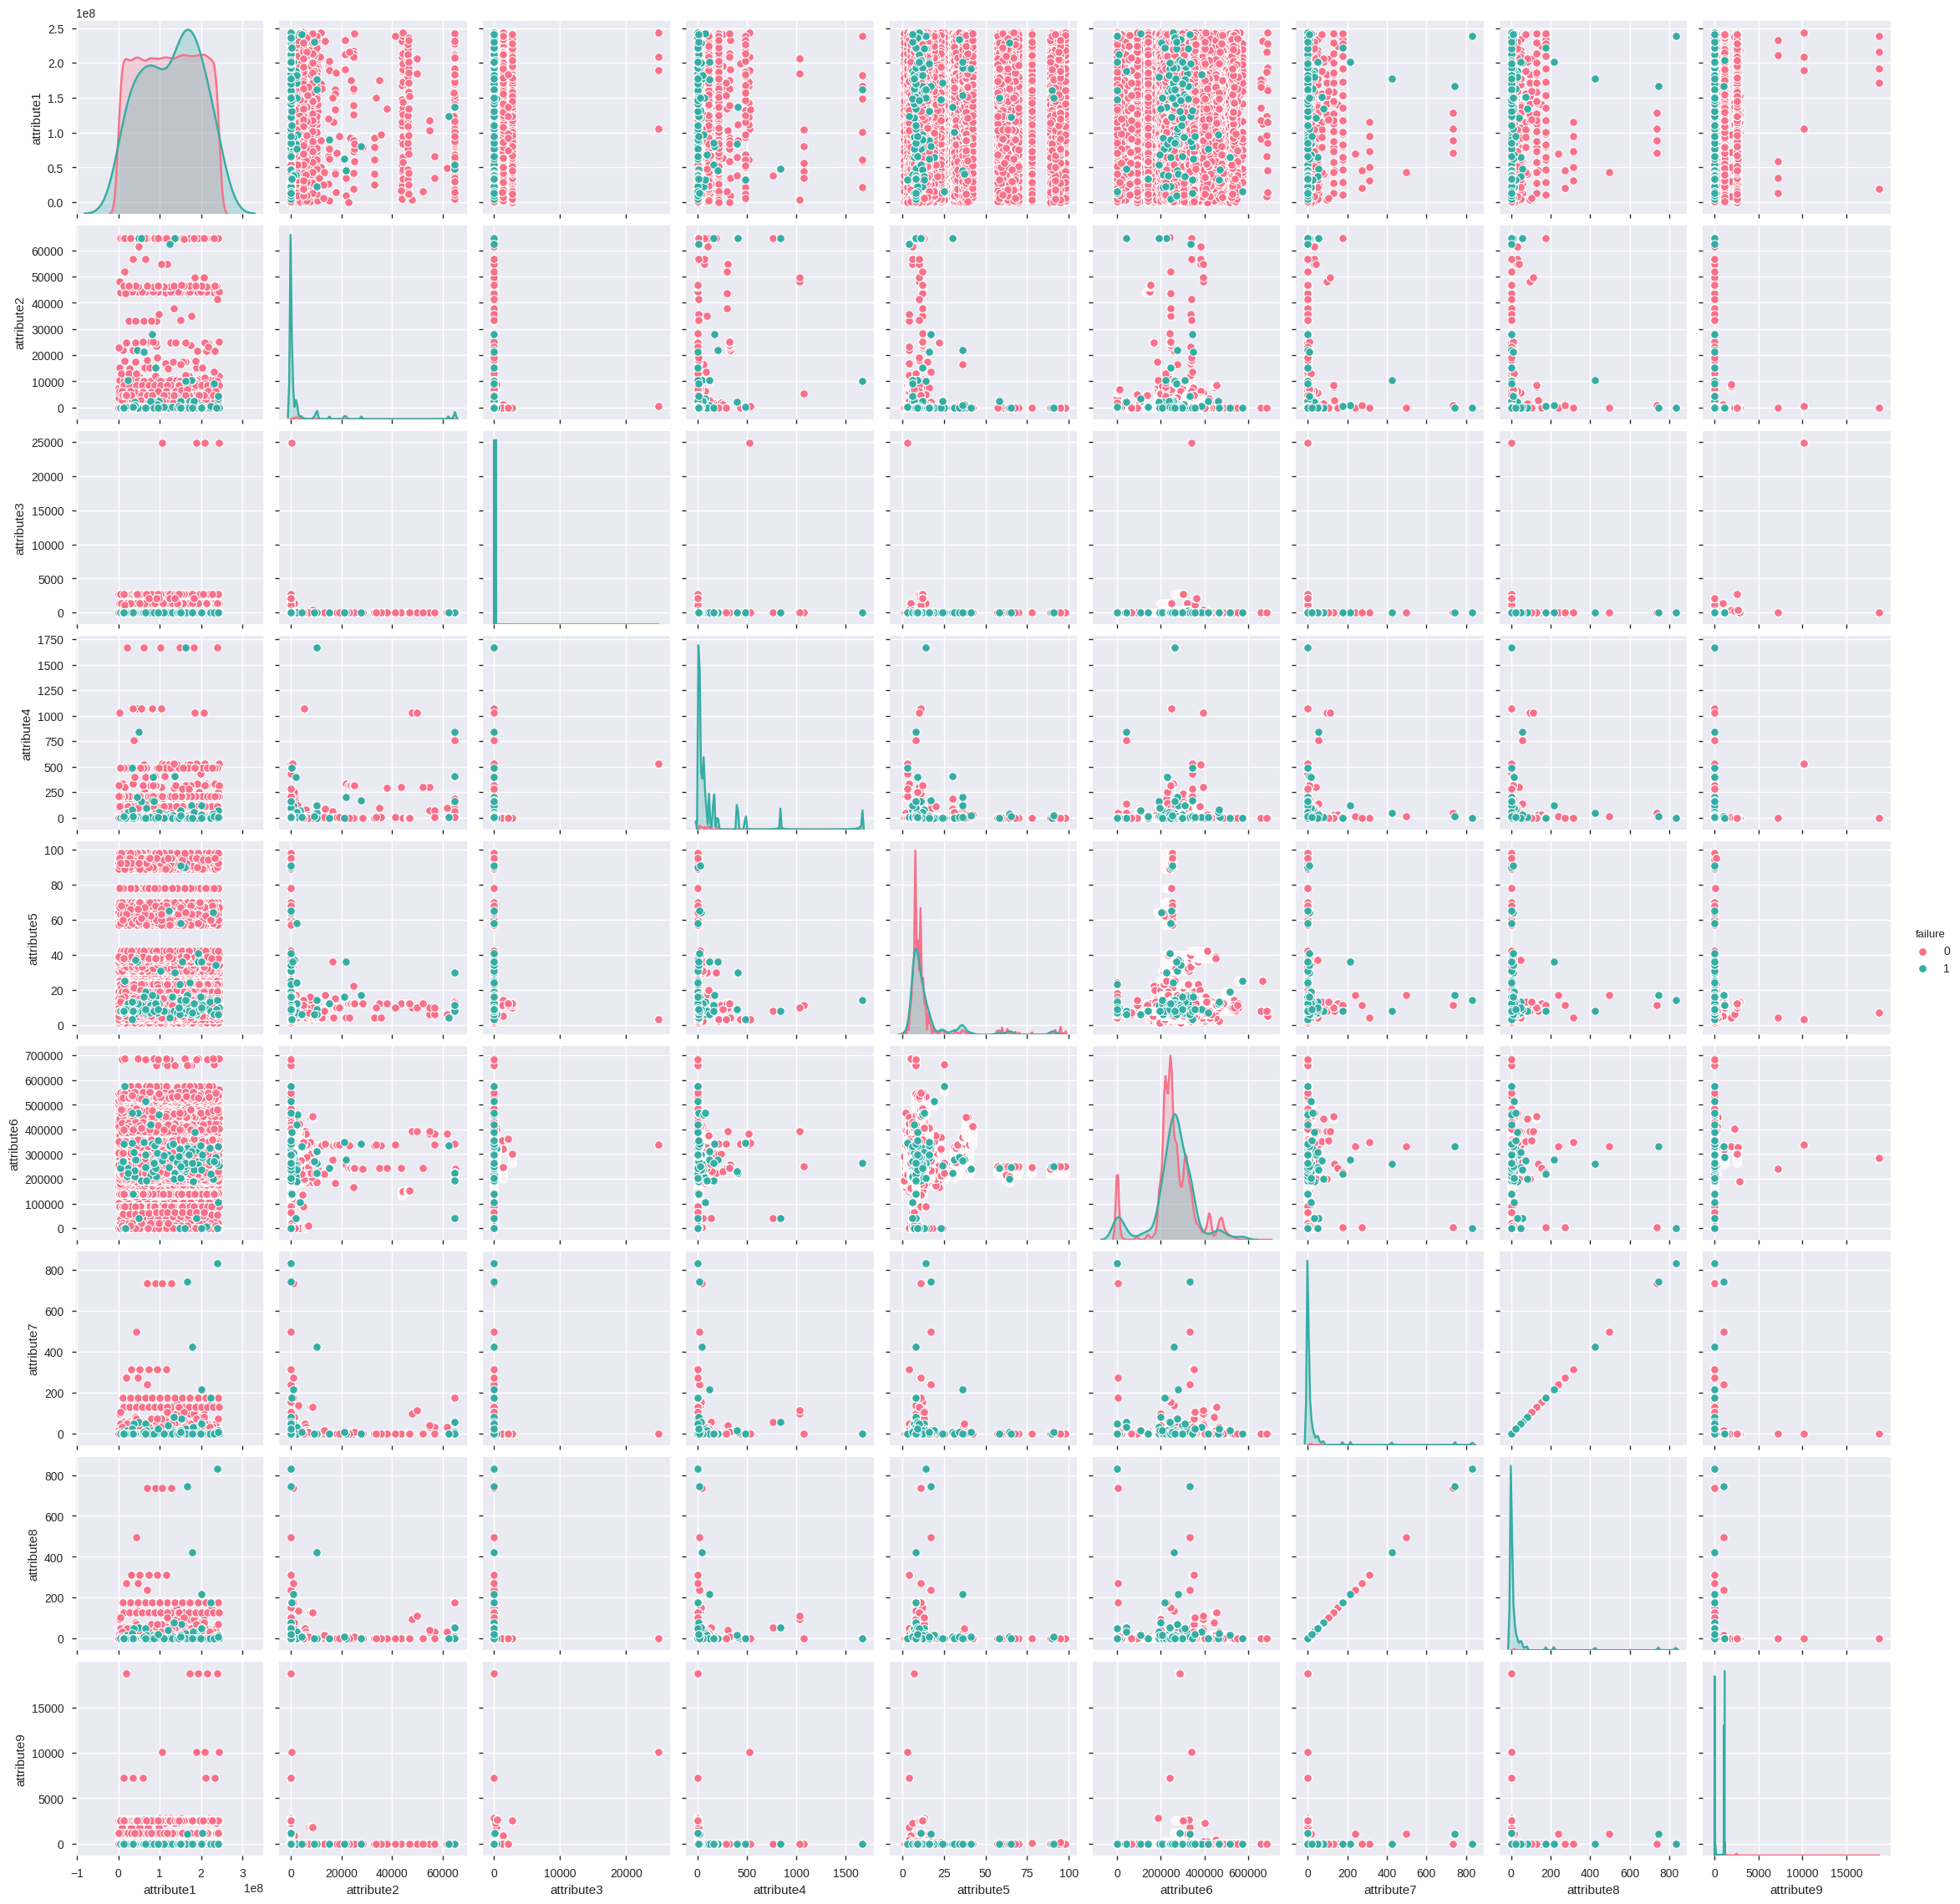

In [0]:
g = sns.pairplot(df, hue="failure", palette="husl")
g

## **Feature Engineering**
We perform feature engineering to create variables in order to take more information out of our variables. 

First, we take out information out of the date column. For example: which month it is, what day, what day of the week, which year, if it was end or start of the month/quarter/year.

Second, we create behavioral features based on the date. We calculate how many days passed between the first and last measure, how many days a device has worked, how many days are left until failure day, how many times the devices was measure, how many days passed between the last measure. 

Third, we split the device tag into different tags by taking the first letters, second, third, forth and fifth label. For example , the device with tag S1F0108is split into S1 or S2 , thn by F01 and finally by 1085. The goal of these variables is to capture the version of devices in case they have an impact on the failure variable.

In [0]:
df = main_etl()
df  

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute8,attribute9,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,active_days,working_day,days_to_failure,measures,measurement_diff,deviceLabel,firstLabel,secondLabel,thirdLabel,fourthLabel,fifthLabel,Is_month_endLabel,Is_month_startLabel,Is_quarter_endLabel,Is_quarter_startLabel,Is_year_endLabel,Is_year_startLabel,minLabel,maxLabel,dateLabel
0,0,215630672,56,0,52,6,407438,0,7,2015,1,1,1,3,1,1420070400,5.0,1.0,5.0,6,0.0,0,0,0,0,1,35,0,1,0,1,0,1,0,3,0
1,0,1650864,56,0,52,6,407438,0,7,2015,1,1,2,4,2,1420156800,5.0,2.0,4.0,6,1.0,0,0,0,0,1,35,0,0,0,0,0,0,0,3,1
2,0,124017368,56,0,52,6,407438,0,7,2015,1,1,3,5,3,1420243200,5.0,3.0,3.0,6,1.0,0,0,0,0,1,35,0,0,0,0,0,0,0,3,2
3,0,128073224,56,0,52,6,407439,0,7,2015,1,1,4,6,4,1420329600,5.0,4.0,2.0,6,1.0,0,0,0,0,1,35,0,0,0,0,0,0,0,3,3
4,0,97393448,56,0,52,6,408114,0,7,2015,1,2,5,0,5,1420416000,5.0,5.0,1.0,6,1.0,0,0,0,0,1,35,0,0,0,0,0,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,0,180917784,0,0,0,5,162645,0,0,2015,4,14,2,3,92,1427932800,95.0,79.0,4.0,83,1.0,1168,2,2,6,58,726,0,0,0,0,0,0,0,40,91
124490,0,33952520,0,0,0,5,162645,0,0,2015,4,14,3,4,93,1428019200,95.0,80.0,3.0,83,1.0,1168,2,2,6,58,726,0,0,0,0,0,0,0,40,92
124491,0,59053184,0,0,0,5,162645,0,0,2015,4,14,4,5,94,1428105600,95.0,81.0,2.0,83,1.0,1168,2,2,6,58,726,0,0,0,0,0,0,0,40,93
124492,0,110545440,0,0,0,5,163047,0,0,2015,4,14,5,6,95,1428192000,95.0,82.0,1.0,83,1.0,1168,2,2,6,58,726,0,0,0,0,0,0,0,40,94


Fourth, we decrease the skewness of attributes 2, 3, 4, 8 and 9. The reason is to capture better those peaks by making them more smooth. In addition, performance of the models improved with this modification.

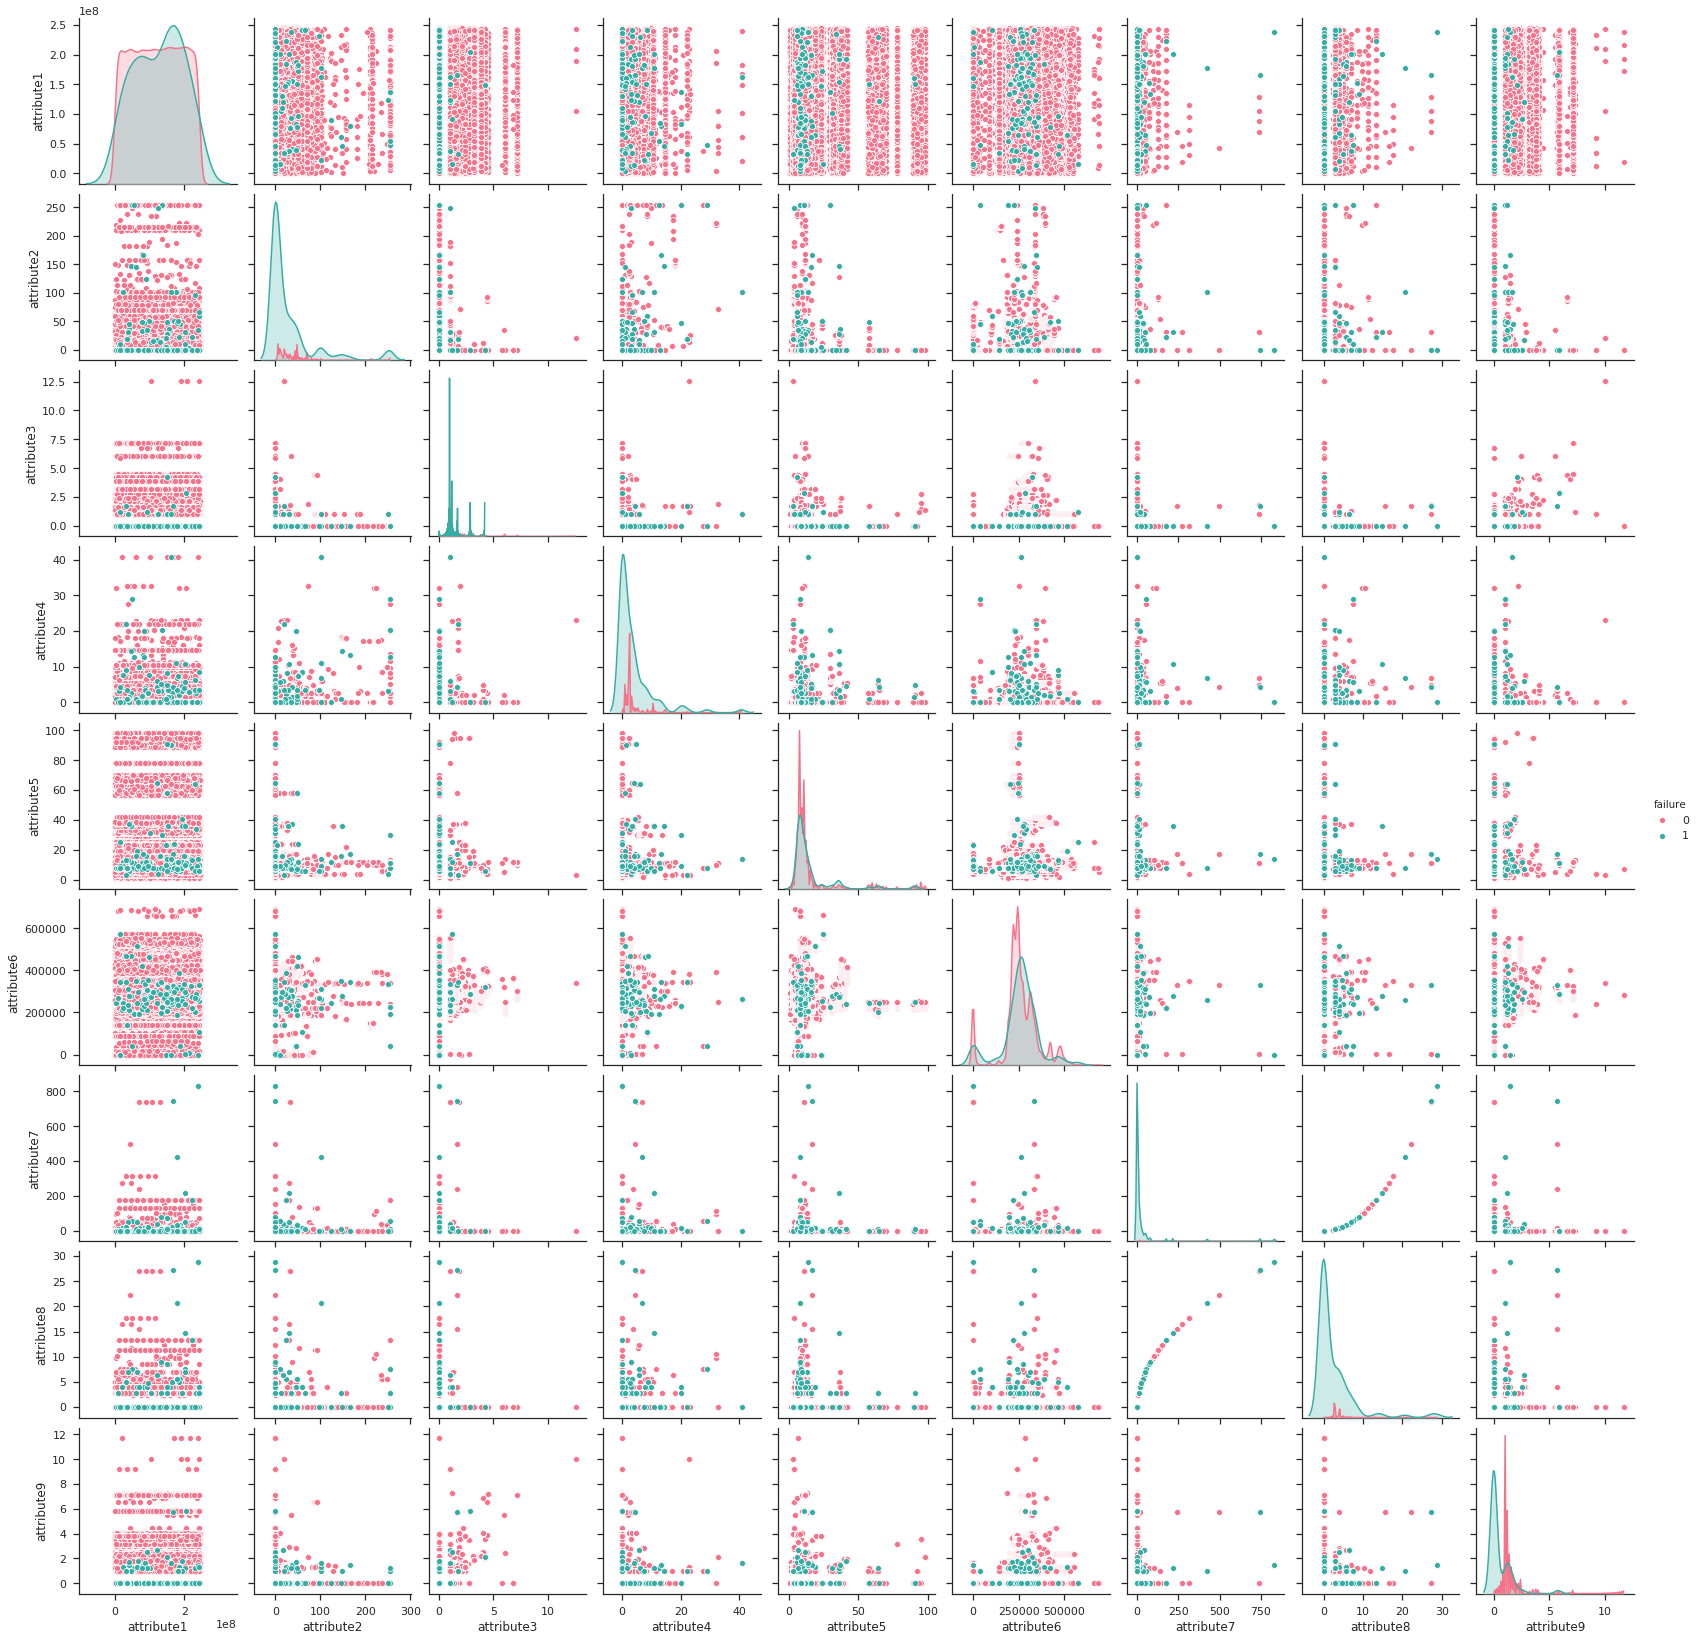

In [0]:
g = sns.pairplot(df, hue="failure", palette="husl")
g

After creating new variables, we transform the dataset into numeric variables in order to work with the algorithms. In addition, we scale the data frame since this improves performance and convergence of the algorithms. 

In [0]:
df = scaling(df, RobustScaler)
df

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute8,attribute9,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,active_days,working_day,days_to_failure,measures,measurement_diff,deviceLabel,firstLabel,secondLabel,thirdLabel,fourthLabel,fifthLabel,Is_month_endLabel,Is_month_startLabel,Is_quarter_endLabel,Is_quarter_startLabel,Is_year_endLabel,Is_year_startLabel,minLabel,maxLabel,dateLabel
0,0.0,1.0,56.0,0.0,52.0,-1.0,2.0,0.0,7.0,0.0,-0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-2.0,-1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-2.0,-1.0
1,0.0,-1.0,56.0,0.0,52.0,-1.0,2.0,0.0,7.0,0.0,-0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,-1.0
2,0.0,0.0,56.0,0.0,52.0,-1.0,2.0,0.0,7.0,0.0,-0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,-1.0
3,0.0,0.0,56.0,0.0,52.0,-1.0,2.0,0.0,7.0,0.0,-0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,-1.0
4,0.0,-0.0,56.0,0.0,52.0,-1.0,2.0,0.0,7.0,0.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-0.0,-1.0,-1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
124490,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-0.0,-1.0,-1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
124491,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-0.0,-1.0,-1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
124492,0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,-0.0,-1.0,-1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0


## **Dimensionality reduction**
After having created new variables, and scaling the data, we perform a dimensionality reduction to 2D in order to observe if with data points are being segmented by the failure condition. 

In [0]:
df = main_etl()
new_df = scaling(df, MinMaxScaler)
  
# New_df is from the random upsample data 
X = new_df.drop('failure', axis=1)
y = new_df['failure']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))
  

T-SNE took 1.1e+03 s
PCA took 0.79 s
Truncated SVD took 0.57 s


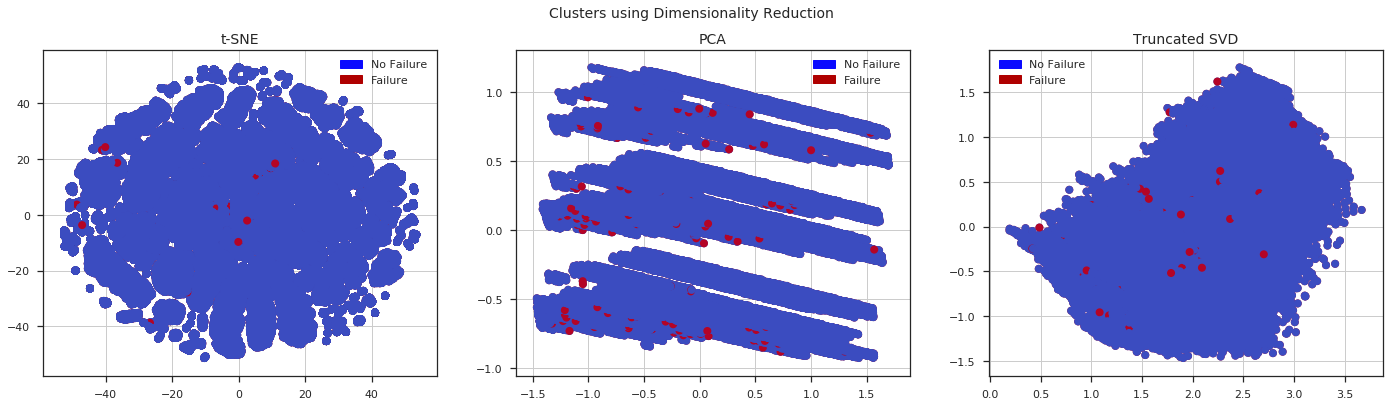

In [0]:
#MIN MAX SCALER
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
labels = ['No Failure', 'Failure']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Failure')
red_patch = mpatches.Patch(color='#AF0000', label='Failure')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

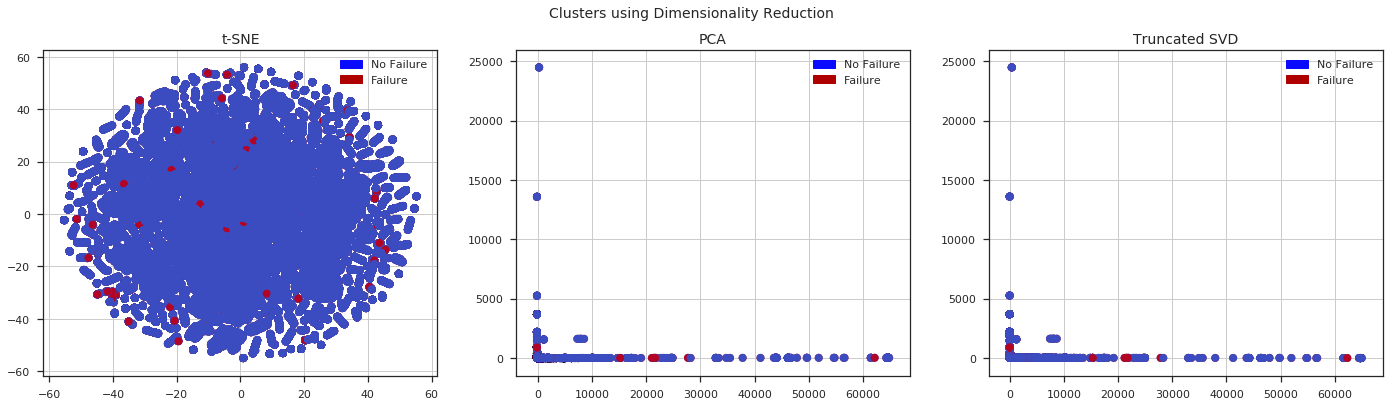

In [0]:
#ROBUST SCALER
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
labels = ['No Failure', 'Failure']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Failure')
red_patch = mpatches.Patch(color='#AF0000', label='Failure')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

I perform dimensionality reduction to look how in two dimensions the data looks like. I perform this task using two different scaling methods: Min Max Scaler and Robust Scaler. By observation, Robust Scaler seems to work better. However, visualization of large datasets in n-dimensions may not be a good technique to take decisions in Machine Learning. Therefore, algorithms were run with Min Max Scaler and with Robust Scaler in order to decide which scaling works better.

# **Modeling**

We will be running different algorithms to predict device failure. Therefore, we define two functions for metrics extraction and for loading the models.




In [0]:
def Metrics(ytest,pred):
  '''Given a vector of predictions and real values, it calculates the accuracy, precision, F1, recall, average precision,
   and it returns a list of all of metrics and the confusion matrix.'''
  accuracy =  accuracy_score(ytest,pred)
  precision = precision_score(ytest,pred)
  F1 = f1_score(ytest,pred)
  recall = recall_score(ytest,pred) 
  average_precision = average_precision_score(ytest,pred)
  metrics = [accuracy, F1, recall, precision, average_precision ]
  confusion = confusion_matrix(ytest,pred)
  return metrics, confusion 

def load_models():
  '''Loads and returns logistic regression, gradient boosting, random forest classifier, XGBoost Classifier and MLP Classifier.'''
  log = LogisticRegression(random_state = 3)
  gbc = GradientBoostingClassifier(random_state = 3)
  rfc = RandomForestClassifier(n_estimators= 300, random_state = 3)
  xg_reg = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, 
                        learning_rate = 0.1, max_depth = 5, n_estimators = 300 , random_state = 3)
  clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
  return log, gbc , rfc , xg_reg , clf



Structure end-to-end code: 

```
df = main_etl()
df = scaling(df, RobustScaler)
X , y = split_x_y(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
new_df, X_train, y_train  = oversampling(X_train,  y_train) #Or other techniques
show_balanced()
model = algorithm.fit(X_train, y_train)
predictions = model.predict(X_test)
metrics , confusion = Metrics(y_test,predictions)
```



## **First Iteration**
We run the following algorithms:
1.   Logistic regression
2.   Gradient Boost
3.   Random Forest
4.   XG Boost Classifier
5.   Neural Net (Multilayer Perceptron)

In the first iteration we use the data scaled and with feature engineering included. 

In [0]:
log, gbc , rfc , xg_reg , clf = load_models()
algorithms=[log, gbc, rfc, xg_reg, clf] 
names=['Logistic','GradientBoost','RandomForest','Xgboost','Neunet']

rows = []
for algorithm in algorithms:
  df = main_etl()
  df = scaling(df, RobustScaler)
  X , y = split_x_y(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
  model = algorithm.fit(X_train, y_train)
  predictions = model.predict(X_test)
  metrics , confusion = Metrics(y_test,predictions)
  rows.append(metrics)

results = pd.DataFrame(rows, columns = ['accuracy', 'F1', 'recall', 'precision', 'average_precision'] , index = names)
results

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[17:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,F1,recall,precision,average_precision
Logistic,0.999036,0.000000,0.000000,0.000000,0.000884
GradientBoost,0.999143,0.058824,0.030303,1.000000,0.031160
RandomForest,0.999384,0.465116,0.303030,1.000000,0.303646
Xgboost,0.999679,0.785714,0.666667,0.956522,0.637976
Neunet,0.999116,0.000000,0.000000,0.000000,0.000884


We see that most algorithms achieve an amazing accuracy but the recall and precision are not good. XGBoost seems to be the best algorithm with high recall and precision. 
These good results in terms of accuracy are due to having a very unbalanced dataset. All the algorithms are classifying the majority of the data (non-failure observations) as non-failure, but they are not recognizing any of the failures cases. 

In our job, we are interested on failure classification, therefore we will focus mainly on recall, precision and F1. 

Why Recall? Recall is the ratio of correctly predicted positive observations to the all observations in actual class. The question recall answers is: Of all the devices that truly failed, how many did we label? 

And What about Precision ? Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answers is of all devices that are labeled as failures, how many actually failed? 

Finaly, F1 score, is the weighted average of Precision and Recall. Therefore, it takes both false positives and false negatives into account. 

Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially when we deal with uneven class distribution. 
Accuracy works best if false positives and false negatives have similar cost which is not our case. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 


In order to help the algorithms to detect those rare events, we will perform oversampling on the minority class by using the bootstrap method with replacement. In other words, we will increase the number of failures to match the number of non-failures. The goal is for the algorithm to learn and recognize a failure easier. 


Non-Failure 99.91 % of the dataset
Failure 0.09 % of the dataset


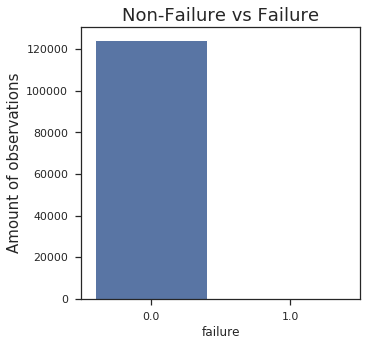

In [0]:
print('Non-Failure', round(df['failure'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Failure', round(df['failure'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

plt.figure(figsize=(5,5))
sns.countplot(df['failure'])
plt.title("Non-Failure vs Failure", fontsize=18)
plt.ylabel("Amount of observations", fontsize=15)
plt.show()

# Oversampling the minority class
We oversample the failure cases in order to match the non-failure cases. We do oversampling only on the training sets (it is a common mistake to perform oversampling on testing sets). It is important to be testing on real data that the algorithm has never seen before. 
We run the same algorithms as before and we would expect the algorithms to perform better this time.



 Balance Data for Non Failure(0) and Failure(1) 

Data Shapes: 
 X TRAIN:  (174144, 35) <class 'pandas.core.frame.DataFrame'> 
 y TRAIN:  (174144,) <class 'pandas.core.series.Series'> 
X TEST:  (37349, 35) <class 'pandas.core.frame.DataFrame'> 
y TEST:  (37349,) <class 'pandas.core.series.Series'> 

TEST GROUP
Size: 37349
Failure percentage: 0.000883557792711987
Non-Failure percentage: 0.999116442207288

TRAIN GROUP
Size: 174144
Failure percentage: 0.5
Non-Failure percentage: 0.5
Non-Failure 69.94 % of the dataset
Failure 69.94 % of the dataset


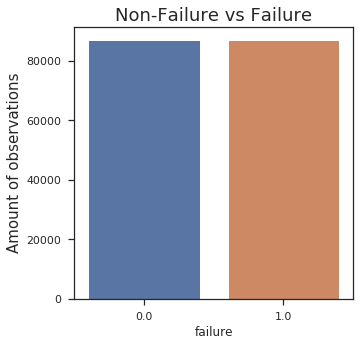

In [0]:
df = main_etl()
df = scaling(df, RobustScaler)
X , y = split_x_y(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
new_df, X_train, y_train  = oversampling(X_train,  y_train)
print('\n Balance Data for Non Failure(0) and Failure(1) \n')
show_balanced()

print('Non-Failure', round(new_df['failure'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Failure', round(new_df['failure'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

plt.figure(figsize=(5,5))
sns.countplot(new_df['failure'])
plt.title("Non-Failure vs Failure", fontsize=18)
plt.ylabel("Amount of observations", fontsize=15)
plt.show()

After having a balanced data set we run the algorithms.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


 
 Algorithm Logistic Regression: 



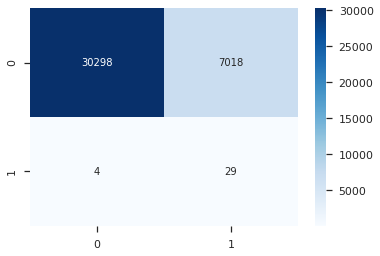

 
 Algorithm Gradient Boost: 



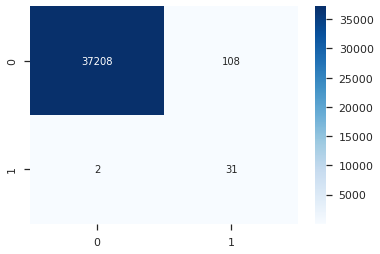

 
 Algorithm Random Forest: 



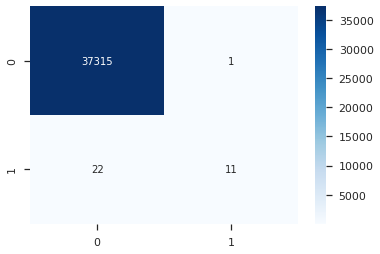

[17:55:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 
 Algorithm XG Boost: 



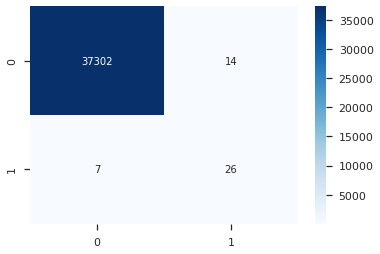

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 
 Algorithm Neural Net: 



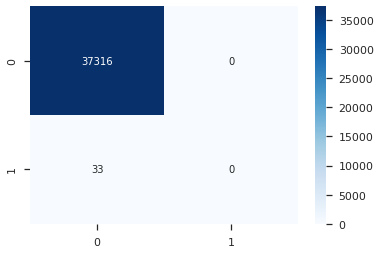

[[0.811989611502316, 0.008192090395480228, 0.8787878787878788, 0.00411522633744856, 0.003723508938086551], [0.9970548073576267, 0.3604651162790698, 0.9393939393939394, 0.22302158273381295, 0.20955867213132198], [0.9993841869929583, 0.4888888888888888, 0.3333333333333333, 0.9166666666666666, 0.30614459408403016], [0.9994377359500923, 0.7123287671232875, 0.7878787878787878, 0.65, 0.5123086334711813], [0.999116442207288, 0.0, 0.0, 0.0, 0.000883557792711987]]


,accuracy,F1,recall,precision,average_precision
Logistic Regression,0.811990,0.008192,0.878788,0.004115,0.003724
Gradient Boost,0.997055,0.360465,0.939394,0.223022,0.209559
Random Forest,0.999384,0.488889,0.333333,0.916667,0.306145
XG Boost,0.999438,0.712329,0.787879,0.650000,0.512309
Neural Net,0.999116,0.000000,0.000000,0.000000,0.000884


In [0]:
algorithms=[log,gbc,rfc,xg_reg,clf] 
names=['Logistic Regression','Gradient Boost','Random Forest','XG Boost','Neural Net']

rows = []
for i, algorithm in enumerate(algorithms):
  name = names[i]
  df = main_etl()
  df = scaling(df, RobustScaler)
  X , y = split_x_y(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
  new_df, X_train, y_train  = oversampling(X_train,  y_train)
  model = algorithm.fit(X_train, y_train)
  predictions = model.predict(X_test)
  metrics , confusion = Metrics(y_test,predictions)
  print(f' \n Algorithm {name}: \n')
  sns.heatmap(confusion , annot=True,fmt='d', cmap='Blues')
  plt.show()
  rows.append(metrics)

print(rows)
results = pd.DataFrame(rows, columns = ['accuracy', 'F1', 'recall', 'precision', 'average_precision'] , index = names)
results

Just by balancing the dataset, we observe great improvements from all algorithms in the recall, precision, and as a consequence, in F1. 

The algorithm XGBoost perform best as having 71% F1 Score. Of all the devices that truly failed, we have label 78% of them as failures (recall). And of all the devices that were labeled as failures, 65% actually failed (precision). The XGBoost algorithm gave us a confusion matrix as follows:

```
                      Predicted Values
                   | Not Fail |    Fail
True    | Not Fail |  37302   |     14
values  | Fail     |     7    |     26

```

where 7 and 14 are the mistakes the algorithm has made. 
  - 7 times the algorithm predicted that it was not a failure which in reality it was.
  - 14 times the algorithm predicted that it was a failure but in reality it wasn't. 

These are the Type I and II error in statistics. An easy way to picture them is to think of the following: 
- Predicting that a pregnant woman is not pregnant is a great example of a type II error, and 
- predicting that a man is pregnant is a type I error. 

Our interest is to minimize false positive and false negatives. On one hand,predicting that something will not fail and it fails (type II error) is more expensive because when a device breaks, the cost of this mistake is equal to the cost replacement or fixing. 

On the other hand, predicting that something will fail and it does not fail (type I error) has the cost of maintenance (which in general is much lower than the cost of replacement or fixing). But if we over predict that devices will fail and they don't, we may increase significantly the cost of doing maintenance.

We would like to have a balance between having false alarms and preventing failures. In our algorithms this is a balance is the F1 Score which balances recall and precision metrics. However, we may accept to have lower precision (due to more false positives cases) to the expense of higher recall (due to predicting better the true failures). For this reason, we will focus more on recall rather than precision. 

Now, I will perform other oversample techniques to check if we can improve the XGBoost performance.

## **SMOTE Oversampling**

We will use the SMOTE algorithm to create a larger sample of minority class to match the size of majority class.

SMOTE is an oversampling algorithm that performs nearest neighbors to create new synthetic data. It was proposed in 2002 by [Chawla et. al](https://arxiv.org/abs/1106.1813) and it has become the most popular algorithms for oversampling. 

As a difference from our previous method of re-sampling where we duplicate randomly selected data observations from the minority class, SMOTE algorithms creates data that is similar to the existing one.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


 
 Algorithm Logistic: 



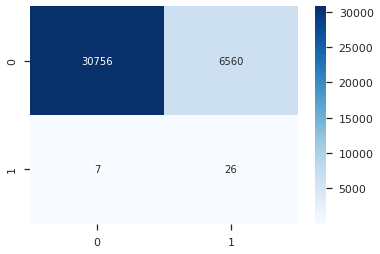

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


 
 Algorithm GradientBoost: 



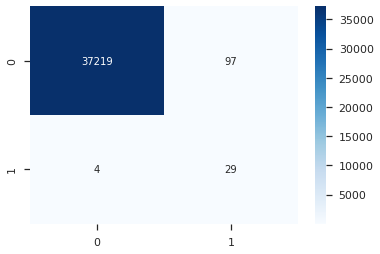

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


 
 Algorithm RandomForest: 



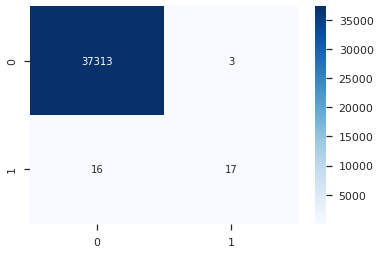

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[18:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


 
 Algorithm Xgboost: 



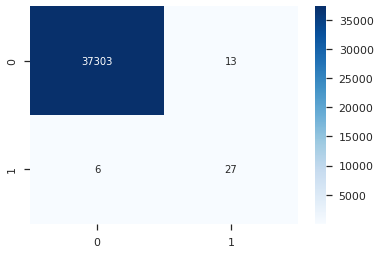

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 
 Algorithm Neunet: 



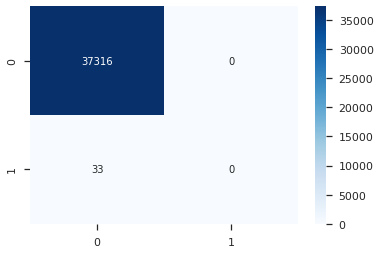

[[0.8241719992503146, 0.007856171627134007, 0.7878787878787878, 0.0039477679927118125, 0.0032977840108936677], [0.99729577766473, 0.36477987421383645, 0.8787878787878788, 0.23015873015873015, 0.20236780017497036], [0.9994912849072264, 0.6415094339622641, 0.5151515151515151, 0.85, 0.43830717953586035], [0.9994912849072264, 0.7397260273972603, 0.8181818181818182, 0.675, 0.5524333741441295], [0.999116442207288, 0.0, 0.0, 0.0, 0.000883557792711987]]


,accuracy,F1,recall,precision,average_precision
Logistic,0.824172,0.007856,0.787879,0.003948,0.003298
GradientBoost,0.997296,0.364780,0.878788,0.230159,0.202368
RandomForest,0.999491,0.641509,0.515152,0.850000,0.438307
Xgboost,0.999491,0.739726,0.818182,0.675000,0.552433
Neunet,0.999116,0.000000,0.000000,0.000000,0.000884


In [0]:
algorithms=[ log , gbc ,rfc , xg_reg, clf] 
names=['Logistic' , 'GradientBoost','RandomForest','Xgboost','Neunet']

rows = []
for i , algorithm in enumerate(algorithms):
  df = main_etl()
  df = scaling(df, RobustScaler)
  X , y = split_x_y(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
  if algorithm == 'xg_reg':
    X_train = X_train.as_matrix()
    X_test = X_test.as_matrix() 
  smt = SMOTE(random_state  = 3, ratio = 1.0)
  X_train, y_train = smt.fit_sample(X_train, y_train)
  model = algorithm.fit(X_train, y_train)
  predictions = model.predict(X_test.as_matrix())
  metrics , confusion = Metrics(y_test,predictions)
  print(f' \n Algorithm {names[i]}: \n')
  sns.heatmap(confusion , annot=True,fmt='d', cmap='Blues')
  plt.show()
  rows.append(metrics)

print(rows)
results = pd.DataFrame(rows, columns = ['accuracy', 'F1', 'recall', 'precision', 'average_precision'] , index = names)
results

We find that XG Boost improves the F1 score because of improving recall to 81% and precision to 67%. 


# SMOTE and cross validation technique

Now I will implement cross validation and oversampling at the same time. Here it is very important to pay attention to the implementation of these two techniques together. Since we will be performing foldings on data, always testing against one fold, we want to make sure that the testing fold is not oversample. If not, we would be inflating those accurate predictions. 

* [...] Why? Consider the simplest method of over-sampling (namely, copying the data point). Let's say every data point from the minority class is copied 6 times before making the splits. If we did a 3-fold validation, each fold has (on average) 2 copies of each point! If our classifier overfits by memorizing its training set, it should be able to get a perfect score on the validation set! Our cross-validation will choose the model that overfits the most. 

I will use the imbalance pipeline which is designed for performing over and under same techniques with cross validation. In addition we will run a grid search in order to look for the best hyper-parameters for our model.

## Random Forest

In [0]:
df = main_etl()
df = scaling(df, RobustScaler)
X , y = split_x_y(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Algorithm parameters
params = {'n_estimators': [50, 100, 200], 'max_depth': [4, 6, 10, 12],'random_state': [13]}
#Imbalance pipeline 
imba_pipeline = make_pipeline(SMOTE(random_state=42), RandomForestClassifier(n_estimators=100, random_state=13))

#Cros validation 
kf = KFold(n_splits=5, random_state=42, shuffle=False)
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall', cv=kf)
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='recall', return_train_score=True)

grid_imba.fit(X_train, y_train)
grid_imba.best_params_


The random forest classifier has worked best with: 4 max depth and 50 estimators, and set with a random state at 13. The accuracy score was 0.87 and a recall of 0.93. However precision dropped significantly to 6% making F1 decrease to 12%. 

In [0]:
y_test_predict = grid_imba.predict(X_test)
print('F1 Score:' , f1_score(y_test, y_test_predict).round(4), 'Recall:', recall_score(y_test, y_test_predict).round(4), 
      'Precision:' , precision_score(y_test, y_test_predict).round(4), 'Accuracy:' ,accuracy_score(y_test, y_test_predict).round(4))

F1 Score: 0.1209 Recall: 0.9394 Precision: 0.0646 Accuracy: 0.9879


## XGBoost classifier

In [0]:
df = main_etl()
df = scaling(df, RobustScaler)
X , y = split_x_y(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train = X_train.as_matrix()
X_test = X_test.as_matrix() 
params = {'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'learning_rate' : [0.1, 0.05, 0.01],
    'random_state': [13]}
imba_pipeline = make_pipeline(SMOTE(random_state=42), XGBClassifier(random_state=13))
kf = KFold(n_splits=5, random_state=42, shuffle=False)
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall', cv=kf)

new_params = {'xgbclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_imba.fit(X_train, y_train)
grid_imba.best_params_

In [0]:
df = main_etl()
df = scaling(df, RobustScaler)
X , y = split_x_y(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train = X_train.as_matrix()
X_test = X_test.as_matrix() 
params = {'n_estimators': [50],
    'max_depth': [4,5,6],
    'learning_rate' : [0.1],
    'random_state': [13]}
imba_pipeline = make_pipeline(SMOTE(random_state=42), XGBClassifier(random_state=13))
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall', cv=kf)

new_params = {'xgbclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_imba.fit(X_train, y_train)
grid_imba.best_params_


In [0]:
y_test_predict = grid_imba.predict(X_test)
print('F1 Score:' , f1_score(y_test, y_test_predict).round(4), 'Recall:', recall_score(y_test, y_test_predict).round(4), 
      'Precision:' , precision_score(y_test, y_test_predict).round(4), 'Accuracy:' ,accuracy_score(y_test, y_test_predict).round(4))

F1 Score: 0.3494 Recall: 0.8788 Precision: 0.218 Accuracy: 0.9971


In [0]:
confusion_matrix(y_test, y_test_predict) ,roc_auc_score(y_test, y_test_predict)

(array([[37212,   104],
        [    4,    29]]), 0.9380004352670234)

Here again, XGBoost did no perform  very well with a F1 score of 34%. Recall was 87%, accuracy 99%, but precision dropped to 22%. 


## XG Boost Parameter Tunning
We will iterate over XG Boost to find the best parameters for our model using SMOTE as our oversampling technique.

In [0]:
depth = [3, 5, 7]
learn_rate = [ 0.01,0.05, 0.07, 0.1]


results = []
for d in depth: 
  for l in learn_rate:
    df = main_etl()
    df = scaling(df, RobustScaler)
    X , y = split_x_y(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
    X_train = X_train.as_matrix()
    X_test = X_test.as_matrix() 
    
    smt = SMOTE(random_state  = 3, ratio = 1.0)
    X_train, y_train = smt.fit_sample(X_train, y_train)

    xg_reg = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, 
                        learning_rate = l , max_depth = d, n_estimators = 300 , random_state = 3)

    model = xg_reg.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = [round(value) for value in predictions]

    # Evaluate predictions
    Accuracy=  (accuracy_score(y_test, predictions)* 100.0).round(2)
    AUC=  (roc_auc_score(y_test, predictions)* 100.0).round(2)
    F1= (f1_score(y_test,predictions)* 100.0).round(2) 
    Recall =  (recall_score(y_test,predictions)* 100.0).round(2) 
    Precision =  (precision_score(y_test,predictions)* 100.0).round(2)
    Average_Precision_Score = (average_precision_score(y_test,predictions)* 100.0).round(2)
    LOG_LOSS =  (log_loss(y_test,predictions)* 100.0).round(2)
    
    metrics = [ d, l , Accuracy, AUC, F1,Recall ,Precision , Average_Precision_Score, LOG_LOSS]
    results.append(metrics)

col_names = ['Depth', 'Learning_rate','Accuracy','AUC' ,'F1','Recall','Precision','Average_Precision_Score','Log_Loss']
df_xgb = pd.DataFrame(results , columns = col_names)
df_xgb

In [0]:
df_xgb.sort_values(by=['F1'], ascending = False).head(54)

,Depth,Learning_rate,Accuracy,AUC,F1,Recall,Precision,Average_Precision_Score,Log_Loss
7,5,0.10,99.96,89.38,77.61,78.79,76.47,60.27,1.39
6,5,0.07,99.95,90.89,73.97,81.82,67.50,55.24,1.76
9,7,0.05,99.96,80.30,71.43,60.61,86.96,52.74,1.48
10,7,0.07,99.95,78.78,69.09,57.58,86.36,49.76,1.57
11,7,0.10,99.95,78.78,67.86,57.58,82.61,47.60,1.66
5,5,0.05,99.93,90.88,66.67,81.82,56.25,46.04,2.50
8,7,0.01,99.89,90.86,56.25,81.82,42.86,35.08,3.88
3,3,0.10,99.73,96.84,38.51,93.94,24.22,22.76,9.16
4,5,0.01,99.71,96.83,36.47,93.94,22.63,21.26,9.99
1,3,0.05,99.66,96.80,32.98,93.94,20.00,18.79,11.65


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.48')

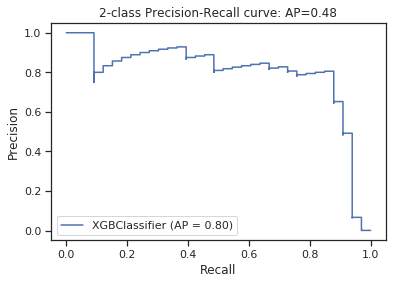

In [0]:
# PLOT THE Precision Recall Curve 
disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision_score(y_test,predictions)))


## Deployment XG Boost

We find that the best parameters is a tree with depth 5 and a learning rate of 0.10.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16:44:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 
 Algorithm Xgboost: 



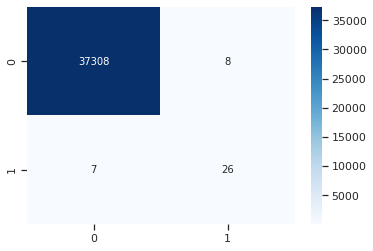

[[0.9995983828214946, 0.7761194029850745, 0.7878787878787878, 0.7647058823529411, 0.6026829650219834]]


,accuracy,F1,recall,precision,average_precision
Xgboost,0.999598,0.776119,0.787879,0.764706,0.602683


In [0]:
xg_reg = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, 
                        learning_rate = 0.1, max_depth = 5, n_estimators = 300 , random_state = 3)
  
algorithms=[xg_reg] 
names=['Xgboost']

rows = []
for i , algorithm in enumerate(algorithms):
  df = main_etl()
  df = scaling(df, RobustScaler)
  
  X , y = split_x_y(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
  X_train = X_train.as_matrix()
  X_test = X_test.as_matrix() 
  
  smt = SMOTE(random_state  = 3, ratio = 1.0)
  X_train, y_train = smt.fit_sample(X_train, y_train)
  
  model = algorithm.fit(X_train, y_train)
  predictions = model.predict(X_test)
  metrics , confusion = Metrics(y_test,predictions)
  
  print(f' \n Algorithm {names[i]}: \n')
  sns.heatmap(confusion , annot=True,fmt='d', cmap='Blues')
  plt.show()
  rows.append(metrics)

print(rows)
results = pd.DataFrame(rows, columns = ['accuracy', 'F1', 'recall', 'precision', 'average_precision'] , index = names)
results


## Results
In our final model, we used a XG Boost algorithm and we arrive to a recall of 78%, a precision of 75%, and a F1 score of 77%. This means that we have a balanced model for both types of errors (false alarms and not predicting failures).


In [0]:
predictions.round()
print(model)
prob = model.predict_proba(X_test)
y_pred_prob = pd.DataFrame(y_test)
y_pred_prob['0']=prob[:,0]
y_pred_prob['1']=prob[:,1]
y_pred_prob.to_csv('perrotta_predictions_20200210.csv')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='reg:linear', random_state=3, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)


In [0]:
y_pred_prob.head(10)

,failure,0,1
12356,0.0,0.982760,0.017240
72619,0.0,1.020982,-0.020982
99674,0.0,1.033398,-0.033398
50505,0.0,1.006119,-0.006119
111284,0.0,1.017647,-0.017647
36979,0.0,0.983555,0.016445
23832,0.0,1.007835,-0.007835
91776,0.0,0.997172,0.002828
92023,0.0,1.059001,-0.059001
111210,0.0,0.994200,0.005800


## Code for output to PDF

In [0]:
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc
#!mv 'drive/My Drive/Colab Notebooks/Fernanda Perrotta.ipynb' ./
#!jupyter nbconvert --to PDF "Fernanda Perrotta.ipynb"